# Data
### Data Selection

In [1]:
import datacq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataprep
from datacq import STATIONS_METADF
import os
os.environ['PATH'] += ':/Library/TeX/texbin'
stations = ['BETN043', 'BETN063', 'BETR222', 'BETR001', 'BETR802'] # 'BETR802', 'BETROO1', 'BELRL01'
pollutants = ["SO2", "NO2", "CO", "O3", "PM2.5", "PM10"]


target_pol = "PM2.5"

# Read era5 parameters from file
era5_features = datacq.era5.get_params()

# Select time range
startYear = 2013
endYear = 2020
years = range(startYear,endYear+1)

Check types of selected stations

In [2]:
stat_types = {}
for stat in stations:
    typ = STATIONS_METADF.loc[stat]['AirQualityStationType']
    area = STATIONS_METADF.loc[stat]['AirQualityStationArea']
    stat_types[stat] = (typ, area)
    print(f'{stat}: {typ} - {area}')

BETN043: industrial - suburban
BETN063: background - rural
BETR222: background - suburban
BETR001: background - urban
BETR802: traffic - urban


### Data Retrieval

In [3]:
#Retrieve data and construct variable name map ({'u10': '10m_u_component_of_wind',...})
df_dict = {}
var_maps = []
for stat in stations:
    print(f'Retrieving data for {stat}')
    df_dict[stat], var_map = datacq.get_df(years, stat, era5_features, pollutants, verbose=False)
    var_maps.append(var_map)

# Add nan columns for missing variables
features = set.union(*[set(df_dict[stat].columns) for stat in stations])
for stat in stations:
    missing_features = [f for f in features if f not in df_dict[stat].columns]
    if len(missing_features) > 0:
        print(f'Following features are missing for {stat}: {missing_features}')
        df_dict[stat][missing_features] = np.nan
var_map = var_maps[0]
var_map['rh'] = 'relative_humidity'
var_map['wsp'] = 'wind_speed'
var_map['wdir'] = 'wind_direction'

Retrieving data for BETN043
Retrieving pollution data...
Retrieving ERA5 data...
Retrieving data for BETN063
Retrieving pollution data...
Retrieving ERA5 data...
Retrieving data for BETR222
Retrieving pollution data...
Retrieving ERA5 data...
Retrieving data for BETR001
Retrieving pollution data...
Retrieving ERA5 data...
Retrieving data for BETR802
Retrieving pollution data...
Retrieving ERA5 data...
Following features are missing for BETR802: ['SO2', 'O3']


In [4]:
#Convert wind variables and calculate humidity
df_src = pd.concat(df_dict)
df_src.index.names = ['station', 'time']
df_src = dataprep.transform_windvars(df_src)
df_src = dataprep.transform_humidity(df_src)
era5_features_short = [f for f in df_src.columns if f not in pollutants]


### Preprocessing

Interpolate pollutants

In [5]:
max_missing = 2
df_interpol_pols = df_src[pollutants].copy()
trainval_index = df_interpol_pols.index.get_level_values('time').year<=2019
nancount1 = df_interpol_pols[trainval_index][pollutants].isna().sum().rename('Before')
df_interpol_pols.loc[trainval_index,pollutants] = df_interpol_pols[trainval_index][pollutants].interpolate(method='linear', limit=max_missing)
nancount2 = df_interpol_pols[trainval_index][pollutants].isna().sum().rename('After')
print('Number of NaNs before and after interpolation:')
print(pd.concat([nancount1, nancount2], axis=1))

Number of NaNs before and after interpolation:
       Before  After
SO2     73003  67743
NO2     11524   4096
CO      21629   5699
O3      72154  66946
PM2.5   13056   9035
PM10    13542   8338


In [6]:
import imp
imp.reload(dataprep)
##Next day variables

# Average era5 features next day
vars_era5 = [v for v in df_src.columns if v not in pollutants]
df_avg = dataprep.calc_aggregate(df_src[vars_era5].copy(),max_nan=4, agg_func='mean')
df_avg = df_avg.add_suffix('_avg')
next_day_features = [df_avg]

# Add min and max era5 features next day
#df_era5_max = dataprep.calc_aggregate(df_src[vars_era5], max_nan=4, agg_func='max').add_suffix('_max')
#df_era5_min = dataprep.calc_aggregate(df_src[vars_era5], max_nan=4, agg_func='min').add_suffix('_min')
#next_day_features += [df_era5_max, df_era5_min]


# T diff next day
tmin = dataprep.calc_aggregate(df_src['t2m'], max_nan=4, agg_func='min')
rhmin = dataprep.calc_aggregate(df_src['rh'], max_nan=4, agg_func='min')
tmax = dataprep.calc_aggregate(df_src['t2m'], max_nan=4, agg_func='max')
tdiff = tmax - tmin
tdiff.rename('t2m_DIFF', inplace=True)
tmax.rename('t2m_MAX', inplace=True)
rhmin.rename('rh_MIN', inplace=True)
next_day_features += [tdiff, tmax, rhmin]


df_nextday = pd.concat(next_day_features, axis=1)
df_nextday = df_nextday.add_suffix('_N')

#Target variable
df_nextday['target_mean'] = dataprep.calc_aggregate(df_src[target_pol], max_nan=4, agg_func='mean')
df_nextday['target_max'] = dataprep.calc_aggregate(df_src[target_pol], max_nan=4, agg_func='max')
df_nextday = df_nextday.shift(-1)

target = 'target_mean'

In [7]:
df_with_time = df_nextday.copy()
df_with_time = (df_with_time
    .pipe(dataprep.add_weeklyvars)
    .pipe(dataprep.add_yearlyvars)
    .pipe(dataprep.add_workday)
    .pipe(dataprep.add_DoW))

In [8]:
#Add pollutants hourly (0,6,12,18), present day
hour_index = df_interpol_pols.index.get_level_values('time').hour
hours = [5,11,17,23]
hour_dfs = []
for h in hours:
    df_temp = df_interpol_pols[hour_index==h].add_suffix(f'_{(h+1)%24}')
    df_temp = dataprep.remove_time(df_temp.copy())
    if h>17:
        df_temp = df_temp.shift(1)
    hour_dfs.append(df_temp)
df_hour_pols = pd.concat(hour_dfs, axis=1)


# Add 24h moving average for pollutants at h=18 present day
df_poll_MA_18 = (dataprep.calc_aggregate(
                        df_src[pollutants].shift(6),
                        max_nan=4, agg_func='mean')
                        .add_suffix('_MA24_18'))

# Add 24h maximum for pollutants and temperature at h=18 present day
df_poll_MAX_18 = (dataprep.calc_aggregate(
                        df_src[pollutants+['t2m']].shift(6),
                        max_nan=4, agg_func='max')
                        .add_suffix('_MAX24_18'))

# Add minimum humidity over the last 24h, at 18h present day
df_hum_MIN_18 = (dataprep.calc_aggregate(
                        df_src['rh'].shift(6),
                        max_nan=4, agg_func='min'))
df_hum_MIN_18.rename('hs_MIN24_18', inplace=True)

# Add average wind speed over the last 24h, at 18h present day
df_wsp_MA24_18 = (dataprep.calc_aggregate(
                        df_src['wsp'].shift(6),
                        max_nan=4, agg_func='min'))
df_wsp_MA24_18.rename('wsp_MA24_18', inplace=True)

df_final = pd.concat([df_with_time,
                        df_poll_MA_18,
                        df_poll_MAX_18,
                        df_hum_MIN_18,
                        df_hour_pols,
                        df_wsp_MA24_18], axis=1)

# Add minimum humidity over the last 24h, at 18h present day
t2m_MIN24_18 = (dataprep.calc_aggregate(
                        df_src['t2m'].shift(6),
                        max_nan=4, agg_func='min'))
df_hum_MIN_18.rename('t2m_MIN24_18', inplace=True)

df_final['t2m_DIFF24_18'] = df_final['t2m_MAX24_18'] - t2m_MIN24_18

### Train-val-test split

In [9]:
df_trainval_dirty = df_final[df_final.index.get_level_values('time').year<=2019].copy()
df_test_dirty = df_final[df_final.index.get_level_values('time').year==2020]

df_path = os.path.join('data','dfs')
if not os.path.exists(df_path):
    os.makedirs(df_path)

Set columns with more than 15% missing values in eather test or train set to NaN

In [10]:
max_nanrate = 0.2
features_all = [f for f in list(df_final) if 'target' not in f]
available_features_dict = {}
df_trainval = df_trainval_dirty.copy()
df_test = df_test_dirty.copy()
for stat in stations:
    total_trainval = len(df_trainval.loc[stat])
    nanrates_trainval = df_trainval_dirty.loc[stat].isna().sum()/total_trainval
    unavailable_vars_trainval = set(nanrates_trainval[nanrates_trainval > max_nanrate].index.values)
    
    total_test = len(df_test.loc[stat])
    nanrates_test = df_test_dirty.loc[stat].isna().sum()/total_test
    unavailable_vars_test = set(nanrates_test[nanrates_test > max_nanrate].index.values)
    unavailable_vars = list(unavailable_vars_trainval|unavailable_vars_test)
    if len(unavailable_vars) > 0:
        print(f'{stat} has {len(unavailable_vars)} unavailable variables: {unavailable_vars}')
        df_trainval.loc[(stat, slice(None)), unavailable_vars] = np.nan
        df_test.loc[(stat, slice(None)), unavailable_vars] = np.nan
    available_features_dict[stat] = list(set(features_all)-set(unavailable_vars))

df_trainval.to_pickle("data/dfs/df_train.pkl")  
df_test.to_pickle("data/dfs/df_test.pkl")

BETR802 has 12 unavailable variables: ['SO2_MAX24_18', 'SO2_18', 'O3_MAX24_18', 'SO2_0', 'O3_6', 'SO2_6', 'SO2_12', 'O3_12', 'SO2_MA24_18', 'O3_18', 'O3_MA24_18', 'O3_0']


### Linear trends

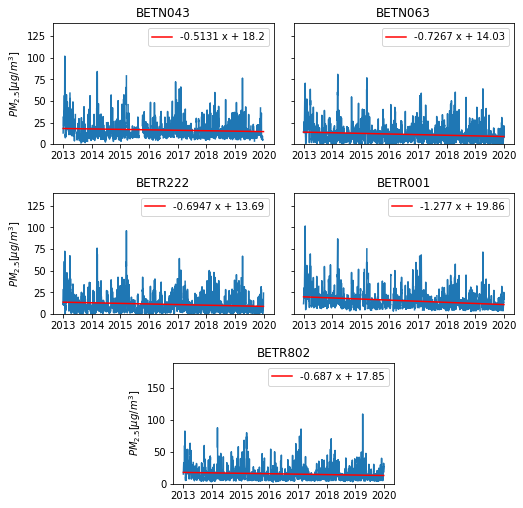

In [11]:
year_in_seconds = 365*24*60*60
nano = 1e9
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8,8))
axes[2][0].set_visible(False)
axes[2][3].set_visible(False)
locations = [(0,0), (0,2), (1,0), (1,2), (2,1)]


for i,(loc,stat) in enumerate(zip(locations,stations)):
    ax = plt.subplot2grid((3,4), loc, colspan=2)
    nonan_series = df_trainval.loc[stat][target].dropna()
    tt = nonan_series.index.values.astype('int64')/(nano*year_in_seconds)
    tt -= tt[0]
    xx = nonan_series.values
    fit = np.polyfit(tt, xx, 1)
    fit_fn = np.poly1d(fit)
    ax.plot(df_trainval.loc[stat][target])
    ax.plot(nonan_series.index.values, fit_fn(tt), 'r', label=f'{str(fit_fn)[2:]}')
    ax.set_title(stat)
    ax.legend()
    plt.ylim(0,140)
    if i==0 or i==2 or i==4:
        ax.set_ylabel(r'$PM_{2.5} [\mu g/m^3]$')
    else:
        ax.axes.yaxis.set_ticklabels([])
    if i==4:
        plt.ylim(0,190)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
plt.savefig(os.path.join("..","figures",f"trends.png"), 
    facecolor='white', edgecolor='none', bbox_inches='tight', dpi=250)

## Variable selection

In [14]:
features_all = df_trainval.columns
targets = [f for f in features_all if f.startswith('target')]
features_all = [f for f in features_all if f not in targets]
poll_features_hour = [f for f in features_all if 'MA' not in f and any([p in f for p in pollutants])]
poll_features_MAX18  = [f for f in features_all if 'MAX' in f and any([p in f for p in pollutants])]
poll_features_MA18  = [f for f in features_all if 'MA' in f and any([p in f for p in pollutants])
                                                            and f not in poll_features_MAX18]
pollutant_features = poll_features_hour+poll_features_MAX18+poll_features_MA18
era5_features_avg = [f for f in features_all if 'avg' in f 
                            and any([p in f for p in era5_features_short])]
time_features = [f for f in features_all if 'week' in f
                                or 'year' in f 
                                or 'work' in f
                                or 'DoW' in f]
special_features = list((set(features_all)
            -set(poll_features_hour)
            -set(poll_features_MA18)
            -set(poll_features_MAX18)
            -set(era5_features_avg)
            -set(time_features)))
print(f'{len(features_all)} features in total')
print(f'\t{len(poll_features_hour)} hourly pollutant features: {poll_features_hour}')
print(f'\t{len(poll_features_MA18)} MA18 pollutant features: {poll_features_MA18}')
print(f'\t{len(poll_features_MAX18)} MAX18 pollutant features: {poll_features_MAX18}')
print(f'\t{len(era5_features_avg)} ERA5 average features (N): {era5_features_avg}')
print(f'\t{len(time_features)} time features: {time_features}')
print(f'\t{len(special_features)} special features: {special_features}')

idx = pd.MultiIndex.from_product([stations, features_all], names=['station', 'Feature'])
FS_results = pd.DataFrame(index=idx)

72 features in total
	24 hourly pollutant features: ['SO2_6', 'NO2_6', 'CO_6', 'O3_6', 'PM2.5_6', 'PM10_6', 'SO2_12', 'NO2_12', 'CO_12', 'O3_12', 'PM2.5_12', 'PM10_12', 'SO2_18', 'NO2_18', 'CO_18', 'O3_18', 'PM2.5_18', 'PM10_18', 'SO2_0', 'NO2_0', 'CO_0', 'O3_0', 'PM2.5_0', 'PM10_0']
	6 MA18 pollutant features: ['SO2_MA24_18', 'NO2_MA24_18', 'CO_MA24_18', 'O3_MA24_18', 'PM2.5_MA24_18', 'PM10_MA24_18']
	6 MAX18 pollutant features: ['SO2_MAX24_18', 'NO2_MAX24_18', 'CO_MAX24_18', 'O3_MAX24_18', 'PM2.5_MAX24_18', 'PM10_MAX24_18']
	23 ERA5 average features (N): ['d2m_avg_N', 't2m_avg_N', 'evabs_avg_N', 'pev_avg_N', 'ro_avg_N', 'e_avg_N', 'slhf_avg_N', 'ssr_avg_N', 'str_avg_N', 'sp_avg_N', 'sshf_avg_N', 'ssrd_avg_N', 'strd_avg_N', 'tp_avg_N', 'blh_avg_N', 'lcc_avg_N', 'hcc_avg_N', 'mcc_avg_N', 'tcc_avg_N', 'wsp_avg_N', 'wdirsin_avg_N', 'wdircos_avg_N', 'rh_avg_N']
	6 time features: ['weeklysin', 'weeklycos', 'yearlysin', 'yearlycos', 'workday', 'DoW']
	7 special features: ['t2m_MAX_N', 'rh_M

In [13]:
print(targets)
target = 'target_mean'


['target_mean', 'target_max']


### Crosscorrelations

In [22]:
from scipy.stats import pearsonr
import itertools

Check all combinations of features for high correlation for all stations

In [16]:
crosscorr_results = {}
for stat in stations:
    print(f'Processing {stat}')
    correlations = {}
    df_stat = df_trainval.loc[stat]
    for feat_a, feat_b in itertools.combinations(features_all, 2):
        df_select = df_stat[[feat_a, feat_b]].dropna()
        if len(df_select)>1000:
            correlations[(feat_a,feat_b)] = pearsonr(df_select[feat_a], df_select[feat_b])
    df_temp = pd.DataFrame.from_dict(correlations, orient='index')
    df_temp.columns = ['PCC', 'p-value']
    crosscorr_results[stat] = df_temp


Processing BETN043
Processing BETN063
Processing BETR222
Processing BETR001
Processing BETR802


In [26]:
import networkx as nx
FS_results['corr_test'] = True
maxcorr_all = 0.95
keep = ['e_avg_N', 'ssr_avg_N', 't2m_MAX_N', 't2m_avg_N',
            'PM2.5_6', 'PM2.5_12', 'PM2.5_0', 'CO_6'] #Keep most sensible features
graphs_long = {}
graphs = {}
for stat in stations:
    result = crosscorr_results[stat]
    #print(result[result.PCC>maxcorr_all].sort_values('PCC', ascending=False).PCC)
    pairs = list(result[result.PCC>maxcorr_all].index)
    g = nx.Graph()
    g.add_edges_from(pairs)
    graphs[stat] = g
    print(f'Connected sets {stat}:')
    for s in nx.find_cliques(g):
        print(f'\t{s} -> {set(s) & set(keep)}')
    to_delete = [f for f in g.nodes if f not in keep]
    FS_results.loc[(stat,to_delete), 'corr_test'] = False

Connected sets BETN043:
	['ssrd_avg_N', 'ssr_avg_N'] -> {'ssr_avg_N'}
	['slhf_avg_N', 'e_avg_N'] -> {'e_avg_N'}
	['t2m_avg_N', 't2m_MAX_N'] -> {'t2m_avg_N', 't2m_MAX_N'}
Connected sets BETN063:
	['ssrd_avg_N', 'ssr_avg_N'] -> {'ssr_avg_N'}
	['PM2.5_MA24_18', 'PM10_MA24_18'] -> set()
	['slhf_avg_N', 'e_avg_N'] -> {'e_avg_N'}
	['t2m_avg_N', 't2m_MAX_N'] -> {'t2m_avg_N', 't2m_MAX_N'}
	['PM10_6', 'PM2.5_6'] -> {'PM2.5_6'}
	['PM2.5_12', 'PM10_12'] -> {'PM2.5_12'}
Connected sets BETR222:
	['PM2.5_0', 'PM10_0'] -> {'PM2.5_0'}
	['ssrd_avg_N', 'ssr_avg_N'] -> {'ssr_avg_N'}
	['pev_avg_N', 'evabs_avg_N'] -> set()
	['CO_6', 'CO_MA24_18'] -> {'CO_6'}
	['PM10_6', 'PM2.5_6'] -> {'PM2.5_6'}
	['slhf_avg_N', 'e_avg_N'] -> {'e_avg_N'}
	['t2m_avg_N', 't2m_MAX_N'] -> {'t2m_avg_N', 't2m_MAX_N'}
Connected sets BETR001:
	['ssrd_avg_N', 'ssr_avg_N'] -> {'ssr_avg_N'}
	['slhf_avg_N', 'e_avg_N'] -> {'e_avg_N'}
	['t2m_avg_N', 't2m_MAX_N'] -> {'t2m_avg_N', 't2m_MAX_N'}
Connected sets BETR802:
	['ssrd_avg_N', 'ssr_a

In [27]:
union_corr_fail = set(FS_results[~FS_results['corr_test']].index.get_level_values(1).values)
inters_corr_fail = set.intersection(
                        *[set(FS_results.loc[stat][FS_results.loc[stat].corr_test==False]
                            .index.values)
                        for stat in stations])
print(f'Intersection of features that failed the correlation test ({len(inters_corr_fail)} total):\n\t'
            f'{inters_corr_fail}')
for stat in stations:
    corr_failed_stat = [f for f in features_all if not FS_results.loc[stat, f]['corr_test']]
    other_failed_stat = set(corr_failed_stat)-inters_corr_fail
    if other_failed_stat:
        print(f'Extra failed features for {stat}: {other_failed_stat}')


Intersection of features that failed the correlation test (2 total):
	{'ssrd_avg_N', 'slhf_avg_N'}
Extra failed features for BETN063: {'PM10_6', 'PM10_MA24_18', 'PM10_12', 'PM2.5_MA24_18'}
Extra failed features for BETR222: {'pev_avg_N', 'PM10_0', 'PM10_6', 'CO_MA24_18', 'evabs_avg_N'}


In [28]:
remaining_features = [f for f in features_all if f not in inters_corr_fail]
print(f'Remaining features ({len(remaining_features)} total): \n\t', remaining_features)

Remaining features (70 total): 
	 ['d2m_avg_N', 't2m_avg_N', 'evabs_avg_N', 'pev_avg_N', 'ro_avg_N', 'e_avg_N', 'ssr_avg_N', 'str_avg_N', 'sp_avg_N', 'sshf_avg_N', 'strd_avg_N', 'tp_avg_N', 'blh_avg_N', 'lcc_avg_N', 'hcc_avg_N', 'mcc_avg_N', 'tcc_avg_N', 'wsp_avg_N', 'wdirsin_avg_N', 'wdircos_avg_N', 'rh_avg_N', 't2m_DIFF_N', 't2m_MAX_N', 'rh_MIN_N', 'weeklysin', 'weeklycos', 'yearlysin', 'yearlycos', 'workday', 'DoW', 'SO2_MA24_18', 'NO2_MA24_18', 'CO_MA24_18', 'O3_MA24_18', 'PM2.5_MA24_18', 'PM10_MA24_18', 'SO2_MAX24_18', 'NO2_MAX24_18', 'CO_MAX24_18', 'O3_MAX24_18', 'PM2.5_MAX24_18', 'PM10_MAX24_18', 't2m_MAX24_18', 'hs_MIN24_18', 'SO2_6', 'NO2_6', 'CO_6', 'O3_6', 'PM2.5_6', 'PM10_6', 'SO2_12', 'NO2_12', 'CO_12', 'O3_12', 'PM2.5_12', 'PM10_12', 'SO2_18', 'NO2_18', 'CO_18', 'O3_18', 'PM2.5_18', 'PM10_18', 'SO2_0', 'NO2_0', 'CO_0', 'O3_0', 'PM2.5_0', 'PM10_0', 'wsp_MA24_18', 't2m_DIFF24_18']


### Detecting noisy features

In [29]:
from featexp import get_trend_stats
FS_results['val_corr'] = -1
trends = {}
train_df = df_trainval[df_trainval.index.get_level_values('time').year<2018]
val_df = df_trainval[df_trainval.index.get_level_values('time').year>=2018]
for stat in stations:
    print(f'Processing {stat}')
    res = get_trend_stats(data=train_df.loc[(stat, slice(None)),available_features_dict[stat]+[target]],
                            target_col=target, 
                            data_test=val_df.loc[stat].copy())
    res.set_index('Feature', inplace=True)
    FS_results.loc[(stat, res.Trend_correlation.index),'val_corr'] = res.Trend_correlation.values
    trends[stat] = res

Processing BETN043
Returning stats for all numeric features
Processing BETN063
Returning stats for all numeric features
Processing BETR222
Returning stats for all numeric features
Processing BETR001
Returning stats for all numeric features
Processing BETR802
Returning stats for all numeric features


In [35]:
threshold_noise = 0.85
noisy_sets = {stat:set(FS_results[FS_results.val_corr<threshold_noise].loc[stat].index.values)
                    for stat in stations}
noisy_intersection = set.intersection(*[noisy_sets[stat] for stat in stations])
print('Intersection: ', noisy_intersection)
for stat in stations:
    print(f'Extra for {stat}: {noisy_sets[stat]-noisy_intersection}')


Intersection:  {'yearlysin', 'weeklycos', 'hs_MIN24_18', 'weeklysin', 'evabs_avg_N', 'rh_avg_N', 'SO2_0', 'ssr_avg_N', 'SO2_6', 'ro_avg_N', 'hcc_avg_N', 'DoW', 'ssrd_avg_N', 'SO2_MAX24_18', 'str_avg_N', 'SO2_18', 't2m_DIFF_N', 'SO2_MA24_18', 'yearlycos', 't2m_DIFF24_18'}
Extra for BETN043: {'NO2_0', 'CO_MAX24_18', 'CO_12', 'CO_6', 'tp_avg_N', 'CO_MA24_18', 'tcc_avg_N', 'sp_avg_N', 'lcc_avg_N', 'CO_18', 't2m_MAX24_18', 'CO_0', 'NO2_18', 'wdirsin_avg_N', 't2m_MAX_N'}
Extra for BETN063: {'SO2_12', 'rh_MIN_N', 'tcc_avg_N', 'NO2_6', 'lcc_avg_N', 'CO_18', 'mcc_avg_N'}
Extra for BETR222: {'pev_avg_N', 'tp_avg_N', 'rh_MIN_N', 'SO2_12', 'tcc_avg_N', 'lcc_avg_N'}
Extra for BETR001: {'pev_avg_N', 'tp_avg_N', 'rh_MIN_N', 'slhf_avg_N', 'strd_avg_N', 'e_avg_N', 'lcc_avg_N', 'sp_avg_N', 'mcc_avg_N', 't2m_MAX24_18', 'SO2_12', 'O3_18', 'wsp_MA24_18', 'O3_MAX24_18', 'O3_0'}
Extra for BETR802: {'NO2_MAX24_18', 'O3_6', 'tp_avg_N', 'rh_MIN_N', 'SO2_12', 'O3_12', 'NO2_6', 'sp_avg_N', 'tcc_avg_N', 'O3_18', '

In [41]:
noisy_era5 = [f for f in noisy_intersection if f in era5_features_avg]
noisy_pollutants = [f for f in noisy_intersection if f in pollutant_features]
noisy_special_features = [f for f in noisy_intersection if f in special_features]
noisy_time = noisy_intersection-set(noisy_era5)-set(noisy_pollutants)-set(noisy_special_features)


print(f'Noisy era5 features: {sorted(noisy_era5)}')
print(f'Noisy pollutants: {sorted(noisy_pollutants)}')
print(f'Noisy special features: {sorted(noisy_special_features)}')
print(f'Noisy temporal features: {sorted(noisy_time)}')


Noisy era5 features: ['evabs_avg_N', 'hcc_avg_N', 'rh_avg_N', 'ro_avg_N', 'ssr_avg_N', 'ssrd_avg_N', 'str_avg_N']
Noisy pollutants: ['SO2_0', 'SO2_18', 'SO2_6', 'SO2_MA24_18', 'SO2_MAX24_18']
Noisy special features: ['hs_MIN24_18', 't2m_DIFF24_18', 't2m_DIFF_N']
Noisy temporal features: ['DoW', 'weeklycos', 'weeklysin', 'yearlycos', 'yearlysin']


In [42]:
to_delete = sorted(noisy_era5)
final_candidates = [c for c in features_all if c not in to_delete and c not in inters_corr_fail]
print(f'Deleted variables ({len(to_delete)} total): ', to_delete)
print(f'{len(final_candidates)} candidates left')

Deleted variables (7 total):  ['evabs_avg_N', 'hcc_avg_N', 'rh_avg_N', 'ro_avg_N', 'ssr_avg_N', 'ssrd_avg_N', 'str_avg_N']
64 candidates left


['BETN043', 'BETN063', 'BETR222', 'BETR001', 'BETR802']
                                         Plots for weeklysin                                          
                                           Train data plots                                           


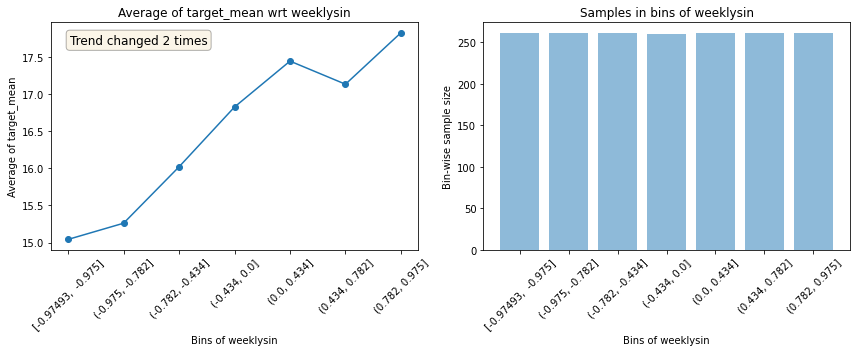

                                           Test data plots                                            


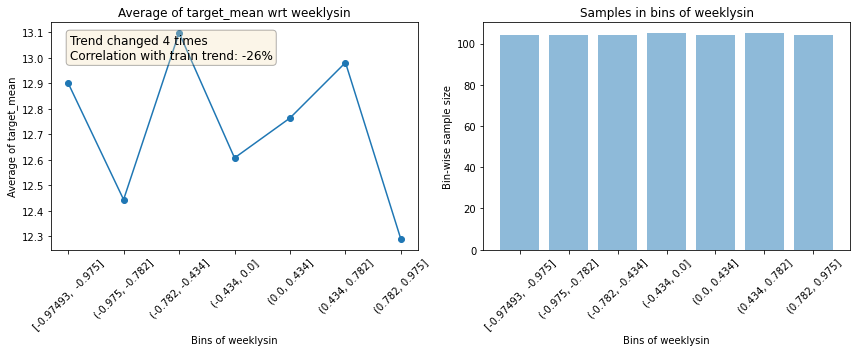

--------------------------------------------------------------------------------------------------------------




In [43]:
from featexp import univariate_plotter
print(stations)
feat = 'weeklysin'
stat = 'BETR001'
feat_train = train_df.loc[stat,[feat,target]]
feat_val = val_df.loc[stat,[feat,target]]
binned_data_train, binned_data_test = (
    univariate_plotter(data=feat_train.copy(),
                     target_col=target,
                     feature=feat,
                     data_test=feat_val))

### Boruta

In [70]:
from BorutaShap import BorutaShap
print('Number of features: ', len(final_candidates))
pvalue = 0.05

sample_frac = 1

n_trials = 120
percentile = 100
sample = False

Number of features:  64


In [71]:
importance_measures = ['shap']
selectors = {}
for stat in stations:
    selectors[stat] = {}
    df_stat = df_trainval.loc[stat]

    selectors[stat] = {}
    candidates = [f for f in final_candidates if f in available_features_dict[stat]]
    df_temp = (df_stat[candidates+[target]]
                        .dropna()
                        .sample(frac=sample_frac))
    X = df_temp[candidates]
    y = df_temp[target]
    for im in importance_measures:
        boruta_im = f'boruta_{im}'
        FS_results.loc[stat][boruta_im] = None
        
        print(f"\t # Training examples: {len(X)}")
        Feature_Selector = BorutaShap(importance_measure=im,
                                classification=False, pvalue=pvalue,
                                percentile=percentile)
        Feature_Selector.fit(X=X, y=y, n_trials=n_trials, sample=sample,
            train_or_test = 'test', normalize=True,
            verbose=True)
        Feature_Selector.TentativeRoughFix()
        FS_results.loc[(stat,Feature_Selector.accepted), boruta_im] = 1
        FS_results.loc[(stat,Feature_Selector.rejected), boruta_im] = -1
        FS_results.loc[(stat,Feature_Selector.tentative), boruta_im] = 0
        selectors[stat][im] = Feature_Selector
    
    file_name = f'FS_results_{stat}_'+'_'.join(sorted(importance_measures))
    if sample:
        file_name += '_sample'
    FS_results.loc[stat].to_csv(os.path.join('data','FS_results',f'{file_name}.csv'))

	 # Training examples: 1947


  0%|          | 0/120 [00:00<?, ?it/s]

Trial 11, 13 features confirmed important: ['sshf_avg_N', 'yearlysin', 'PM2.5_18', 'tp_avg_N', 'PM2.5_MA24_18', 'PM2.5_MAX24_18', 'PM10_18', 'PM2.5_12', 'blh_avg_N', 't2m_DIFF_N', 'wdircos_avg_N', 'wdirsin_avg_N', 'wsp_avg_N']
Trial 13, 14 features confirmed important: ['PM2.5_0', 'sshf_avg_N', 'yearlysin', 'PM2.5_18', 'tp_avg_N', 'PM2.5_MA24_18', 'PM2.5_MAX24_18', 'PM10_18', 'PM2.5_12', 'blh_avg_N', 't2m_DIFF_N', 'wdircos_avg_N', 'wdirsin_avg_N', 'wsp_avg_N']
Trial 17, 15 features confirmed important: ['PM2.5_0', 'sshf_avg_N', 'yearlysin', 'PM10_12', 'PM2.5_18', 'tp_avg_N', 'PM2.5_MA24_18', 'PM2.5_MAX24_18', 'PM10_18', 'PM2.5_12', 'blh_avg_N', 't2m_DIFF_N', 'wdircos_avg_N', 'wdirsin_avg_N', 'wsp_avg_N']
Trial 20, 16 features confirmed important: ['PM2.5_0', 'sshf_avg_N', 'yearlysin', 'PM10_12', 'PM2.5_18', 'tp_avg_N', 'PM2.5_MA24_18', 'd2m_avg_N', 'PM2.5_MAX24_18', 'PM10_18', 'PM2.5_12', 'blh_avg_N', 't2m_DIFF_N', 'wdircos_avg_N', 'wdirsin_avg_N', 'wsp_avg_N']
Trial 25, 17 features co

  0%|          | 0/120 [00:00<?, ?it/s]

Trial 11, 21 features confirmed important: ['NO2_0', 'yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'tp_avg_N', 'strd_avg_N', 'NO2_6', 'PM10_MA24_18', 'mcc_avg_N', 'NO2_MA24_18', 'PM10_18', 'NO2_18', 'sshf_avg_N', 'd2m_avg_N', 't2m_avg_N', 'PM2.5_MAX24_18', 'NO2_12', 'wsp_avg_N']
Trial 17, 22 features confirmed important: ['NO2_0', 'yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'tp_avg_N', 'strd_avg_N', 'NO2_6', 'PM10_MA24_18', 'mcc_avg_N', 'NO2_MA24_18', 'PM10_18', 'NO2_18', 't2m_DIFF_N', 'sshf_avg_N', 'd2m_avg_N', 't2m_avg_N', 'PM2.5_MAX24_18', 'NO2_12', 'wsp_avg_N']
Trial 29, 23 features confirmed important: ['NO2_0', 'yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'tp_avg_N', 'strd_avg_N', 'NO2_6', 'PM2.5_6', 'PM10_MA24_18', 'mcc_avg_N', 'NO2_MA24_18', 'PM10_18', 'NO2_18', 't2m_DIFF_N', 'sshf_avg_N', 'd2m_avg_N', 't2m_avg_N', 'PM2.5_MAX24_18', 'NO2_12', 'wsp_

  0%|          | 0/120 [00:00<?, ?it/s]

Trial 11, 17 features confirmed important: ['wdirsin_avg_N', 'sshf_avg_N', 'yearlysin', 'PM2.5_18', 'tp_avg_N', 'PM2.5_MA24_18', 'd2m_avg_N', 'strd_avg_N', 't2m_avg_N', 'PM10_MA24_18', 'NO2_MA24_18', 'PM10_18', 'NO2_18', 'NO2_12', 'wdircos_avg_N', 'blh_avg_N', 'wsp_avg_N']
Trial 14, 20 features confirmed important: ['yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'tp_avg_N', 'strd_avg_N', 'PM2.5_12', 'PM10_MA24_18', 'wsp_MA24_18', 'mcc_avg_N', 'NO2_MA24_18', 'PM10_18', 'NO2_18', 'sshf_avg_N', 'd2m_avg_N', 't2m_avg_N', 'NO2_12', 'wsp_avg_N']
Trial 20, 21 features confirmed important: ['yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'PM2.5_0', 'tp_avg_N', 'strd_avg_N', 'PM2.5_12', 'PM10_MA24_18', 'wsp_MA24_18', 'mcc_avg_N', 'NO2_MA24_18', 'PM10_18', 'NO2_18', 'sshf_avg_N', 'd2m_avg_N', 't2m_avg_N', 'NO2_12', 'wsp_avg_N']
Trial 23, 22 features confirmed important: ['yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', '

  0%|          | 0/120 [00:00<?, ?it/s]

Trial 11, 20 features confirmed important: ['yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'tp_avg_N', 'strd_avg_N', 'PM2.5_6', 'PM2.5_12', 'mcc_avg_N', 'NO2_MA24_18', 'PM10_18', 'NO2_18', 't2m_DIFF_N', 'sshf_avg_N', 'd2m_avg_N', 'PM2.5_MAX24_18', 'NO2_12', 'wsp_avg_N']
Trial 14, 21 features confirmed important: ['yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'tp_avg_N', 'PM10_MAX24_18', 'strd_avg_N', 'PM2.5_6', 'PM2.5_12', 'mcc_avg_N', 'NO2_MA24_18', 'PM10_18', 'NO2_18', 't2m_DIFF_N', 'sshf_avg_N', 'd2m_avg_N', 'PM2.5_MAX24_18', 'NO2_12', 'wsp_avg_N']
Trial 20, 22 features confirmed important: ['yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'tp_avg_N', 'PM10_MAX24_18', 'strd_avg_N', 'NO2_6', 'PM2.5_6', 'PM2.5_12', 'mcc_avg_N', 'NO2_MA24_18', 'PM10_18', 'NO2_18', 't2m_DIFF_N', 'sshf_avg_N', 'd2m_avg_N', 'PM2.5_MAX24_18', 'NO2_12', 'wsp_avg_N']
Trial 29, 24 featu

  0%|          | 0/120 [00:00<?, ?it/s]

Trial 11, 14 features confirmed important: ['sshf_avg_N', 'yearlysin', 'PM2.5_18', 'tp_avg_N', 'PM2.5_MA24_18', 'strd_avg_N', 'PM10_MA24_18', 'PM10_18', 'PM2.5_12', 'NO2_12', 't2m_DIFF_N', 'wdircos_avg_N', 'blh_avg_N', 'wsp_avg_N']
Trial 14, 18 features confirmed important: ['sshf_avg_N', 'yearlysin', 'PM2.5_18', 'tp_avg_N', 'PM2.5_MA24_18', 'd2m_avg_N', 'strd_avg_N', 'sp_avg_N', 'PM10_MA24_18', 'mcc_avg_N', 't2m_MAX24_18', 'PM10_18', 'PM2.5_12', 'NO2_12', 't2m_DIFF_N', 'wdircos_avg_N', 'blh_avg_N', 'wsp_avg_N']
Trial 17, 19 features confirmed important: ['yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'tp_avg_N', 'strd_avg_N', 'PM2.5_12', 'PM10_MA24_18', 'sp_avg_N', 'mcc_avg_N', 't2m_MAX24_18', 'PM10_18', 't2m_DIFF_N', 'sshf_avg_N', 'd2m_avg_N', 'NO2_12', 'wsp_avg_N']
Trial 23, 22 features confirmed important: ['yearlysin', 'PM2.5_18', 'PM2.5_MA24_18', 'wdircos_avg_N', 'wdirsin_avg_N', 'blh_avg_N', 'tp_avg_N', 'strd_avg_N', 'e_avg_N', 'PM2.5_6'

In [48]:
FS_results

corr_test  val_corr boruta_shap_11 boruta_gini_11  \
station Feature                                                         
BETN043 SO2              True  0.614415             -1             -1   
        SO2_MAX          True  0.790214             -1             -1   
        SO2_MA           True  0.425638             -1             -1   
        NO2              True  0.973534             -1             -1   
        NO2_MAX          True  0.916899             -1             -1   
...                       ...       ...            ...            ...   
BETR001 weekly_sin       True -0.951904             -1             -1   
        weekly_cos       True -0.966285             -1             -1   
        yearly_sin       True  0.833895              1             -1   
        yearly_cos       True  0.400657             -1             -1   
        workday          True -1.000000             -1             -1   

                   boruta_shap_23 boruta_gini_23  
station Feature                                   
BETN043 SO2                    -1             -1  
        SO2_MAX                -1             -1  
        SO2_MA                 -1             -1  
        NO2                    -1             -1  
        NO2_MAX                -1             -1  
...                           ...            ...  
BETR001 weekly_sin              0             -1  
        weekly_cos             -1             -1  
        yearly_sin             -1             -1  
        yearly_cos             -1             -1  
        workday                -1             -1  

[276 rows x 6 columns]

In [65]:
for stat in stations:
    print(stat)
    selectors[stat]['shap'].TentativeRoughFix()

BETN043
1 tentative features are now accepted: ['strd_avg_N']
2 tentative features are now rejected: ['PM10_MA24_18' 'O3_MAX24_18']
BETN063
4 tentative features are now accepted: ['NO2_MAX24_18' 'CO_18' 't2m_MAX24_18' 'PM2.5_6']
1 tentative features are now rejected: ['PM10_12']
BETR222
2 tentative features are now accepted: ['CO_6' 'PM2.5_6']
4 tentative features are now rejected: ['t2m_MAX_N' 'NO2_6' 'PM10_12' 'PM2.5_MAX24_18']
BETR001
1 tentative features are now accepted: ['SO2_12']
2 tentative features are now rejected: ['PM10_MAX24_18' 'NO2_6']
BETR802
2 tentative features are now accepted: ['PM10_12' 'lcc_avg_N']
0 tentative features are now rejected: []


In [49]:
file_name = 'FS_results'+'_'.join(sorted(importance_measures))
if sample:
    file_name += '_sample'
FS_results.to_csv(os.path.join('data',f'{file_name}.csv'))

In [ ]:
for stat in stations:
    shap_success = set([f for f in final_candidates if FS_results.loc[stat,f]['boruta_shap_23']==1])
    gini_success = set([f for f in final_candidates if FS_results.loc[stat,f]['boruta_gini_23']==1])
    both_success = shap_success & gini_success
    print(f'Stations {stat}:')
    print(f'Both successfull: {both_success}')
    print(f'Only Shap: {shap_success-both_success}')
    print(f'Only Gini: {gini_success-both_success}')
    print()


NameError: name 'stations' is not defined